In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from time import time
import copy as copy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.multiclass import OneVsRestClassifier, OutputCodeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors.kde import KernelDensity
from sklearn.linear_model import LassoLars

%matplotlib inline

# Working with data
## Non preprocessed data

In [258]:
data = pd.read_csv(open("dataset_diabetes/diabetic_data.csv"))
print('Columns\n', data.columns)
data.drop('weight', axis=1, inplace=True)
data.drop('payer_code', axis=1, inplace=True)
data.drop('medical_specialty', axis=1, inplace=True)
n_samples = data.shape[0]
print('num of samples', n_samples)
n_features = data.shape[1]
print('num of features', n_features)

Columns
 Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
num of samples 101766
num of features 47


## Preprocessed data

In [71]:
data = pd.read_csv(open("dataset_diabetes/diabetic_data.csv"))
print('Columns\n', data.columns)
data.drop('weight', axis=1, inplace=True)
data.drop('payer_code', axis=1, inplace=True)
data.drop('medical_specialty', axis=1, inplace=True)


data = data.drop_duplicates(subset='patient_nbr')
data = data[data['discharge_disposition_id'] != 11]
data = data[data['discharge_disposition_id'] != 13]
data = data[data['discharge_disposition_id'] != 14]
data = data[data['discharge_disposition_id'] != 19]
data = data[data['discharge_disposition_id'] != 20]
data = data[data['discharge_disposition_id'] != 21]

n_samples = data.shape[0]
print('num of samples', n_samples)
n_features = data.shape[1]
print('num of features', n_features)

Columns
 Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
num of samples 69973
num of features 47


### Encoding of categorical features

In [259]:
LE = LabelEncoder()

In [260]:
# Transform the categorical features

s = 1
for column in data.columns[:-1]:
    LE.fit(data[column])
    data[column] = s * LE.transform(data[column])

#### All data and relevant medical data

In [261]:
med_col = data.columns[9:-1]
drug_col = data.columns[21:-3]
X_med = np.asarray(data[med_col])
X_drug = np.asarray(data[drug_col])

LE.fit(data['readmitted'])
data['readmitted'] = LE.transform(data['readmitted'])
print ('Label encoding for readmitted', LE.classes_)

X, y = np.asarray(data[data.columns[2:-1]]), np.asarray(data['readmitted'])

Label encoding for readmitted ['<30' '>30' 'NO']


### Data split

In [262]:
X_train_med, X_test_med, y_train, y_test = train_test_split(X_med, y, 
                                                                    test_size=0.5, random_state=1, stratify=y)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [264]:
X_train_drug, X_test_drug, y_train, y_test = train_test_split(X_drug, y, 
                                                                    test_size=0.5, random_state=1, stratify=y)

In [265]:
X_samp, X_remain, y_samp, y_remain = train_test_split(X, y, test_size=0.9, random_state=1, stratify=y)

### Label binarization
Here we use binariztion to predict readmission in any time 

In [266]:
# LE.fit(data['readmitted'])
# data['readmitted'] = LE.transform(data['readmitted'])
# print ('Label encoding for readmitted', LE.classes_)

In [267]:
def binarization (y, y_train, y_test, param=2):
    
    y_bin = np.zeros(len(y))
    y_bin_train = np.zeros(len(y_train))
    y_bin_test = np.zeros(len(y_test))

    for i in range(len(y)):
        if y[i] < param:
            y_bin[i] = 1
        else:
            y_bin[i] = 0
    
    for i in range(len(y_train)):
        if y_train[i] < param:
            y_bin_train[i] = 1
        else:
            y_bin_train[i] = 0

    for i in range(len(y_test)):
        if y_test[i] < param:
            y_bin_test[i] = 1
        else:
            y_bin_test[i] = 0

    return y_bin, y_bin_train, y_bin_test

In [268]:
y_bin, y_bin_train, y_bin_test = binarization(y, y_train, y_test, param=1)

In [269]:
y_bin.sum()  len(y_bin)

0.11159915885462728

--------------------------------------------------------------------------

## Emergency visits

In [15]:
#Number of emergency visits of the patient in the year preceding the encounter

n_emergency = np.asarray(data['number_emergency'])
emergency_values = np.unique(n_emergency)

In [16]:
#Age intervals, for example [10, 20)

ages = np.asarray(data["age"])
ages_types = np.unique(ages)

In [17]:
probability = []
for age in ages_types:
    emergency = n_emergency[np.where(ages == age)]
    probability.append(emergency.sum() / len(emergency))
    print(age, emergency.sum() / len(emergency))

0 0.0310559006211
1 0.156295224313
2 0.578153289077
3 0.482119205298
4 0.35446566856
5 0.222183588317
6 0.155628697238
7 0.131003529231
8 0.144269349305
9 0.13104189044


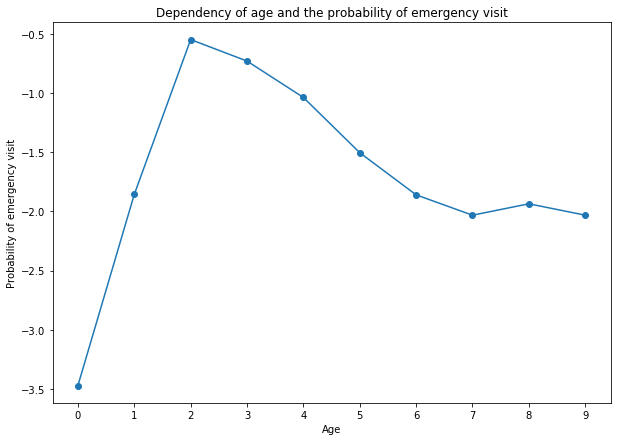

In [18]:
fig = plt.figure(figsize=(10,7))
plt.plot(np.arange(len(ages_types)), np.log(probability), marker='o')
plt.xticks(np.arange(len(ages_types)), ages_types)
plt.title("Dependency of age and the probability of emergency visit")
plt.xlabel("Age")
plt.ylabel("Probability of emergency visit")

-------------------

# Visualization

### PCA to visualize

In [19]:
n_components = 2

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_samp)
print("PCA is done in %0.3fs" % (time() - t0))

X_train_pca = pca.transform(X_samp)
# X_test_pca = pca.transform(X_test)
print("Transformation is done in %0.3fs" % (time() - t0))

PCA is done in 0.303s
Transformation is done in 0.304s


In [17]:
X_train_pca = np.loadtxt('PCA.txt')

In [18]:
np.unique(data['race'])

array([0, 1, 2, 3, 4, 5])

In [19]:
np.unique(X_train[:, 0])

array([0, 1, 2, 3, 4, 5])

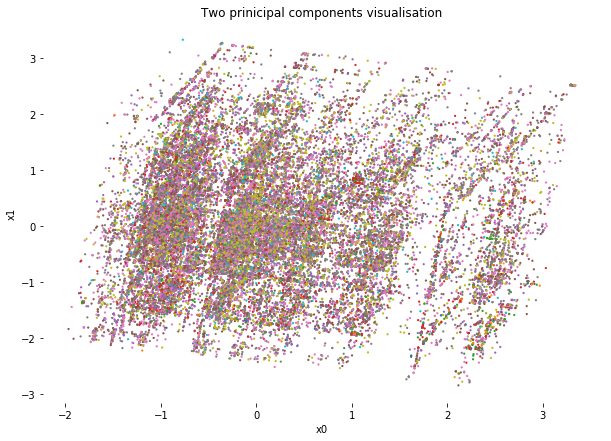

In [20]:
x0 = [x[0] for x in X_train_pca]
x1 = [x[1] for x in X_train_pca]
colors = [cm.Vega10((y_) / max(X_train[:, 2])) for y_ in X_train[:, 2]]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
plt.xlabel('x0')
plt.ylabel('x1')
# ax.set_xlim([-2e14, 2e14])
# ax.set_ylim([-0.25e14, 0.25e14])
plt.title('Two prinicipal components visualisation')

### KernelPCA

In [25]:
n_components = 3

t0 = time()
kpca = KernelPCA(n_components=n_components, kernel='poly').fit(X_samp)
print("KernelPCA is done in %0.3fs" % (time() - t0))

X_train_kpca = kpca.transform(X_samp)
# X_test_kpca = kpca.transform(X_test_med)
print("Transformation is done in %0.3fs" % (time() - t0))

KernelPCA is done in 8.165s
Transformation is done in 13.743s


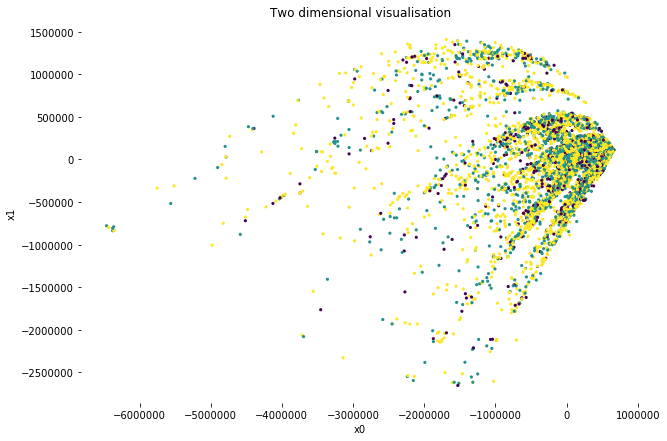

In [49]:
x0 = [x[0] for x in X_train_kpca]
x1 = [x[1] for x in X_train_kpca]
# colors = [cm.Vega10((y_) / max(y_train)) for y_ in y_bin_train]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=y_samp, edgecolor = 'none', s = 10)
plt.xlabel('x0')
plt.ylabel('x1')
# ax.set_xlim([-2e14, 2e14])
# ax.set_ylim([-0.25e14, 0.25e14])
plt.title('Two dimensional visualisation')

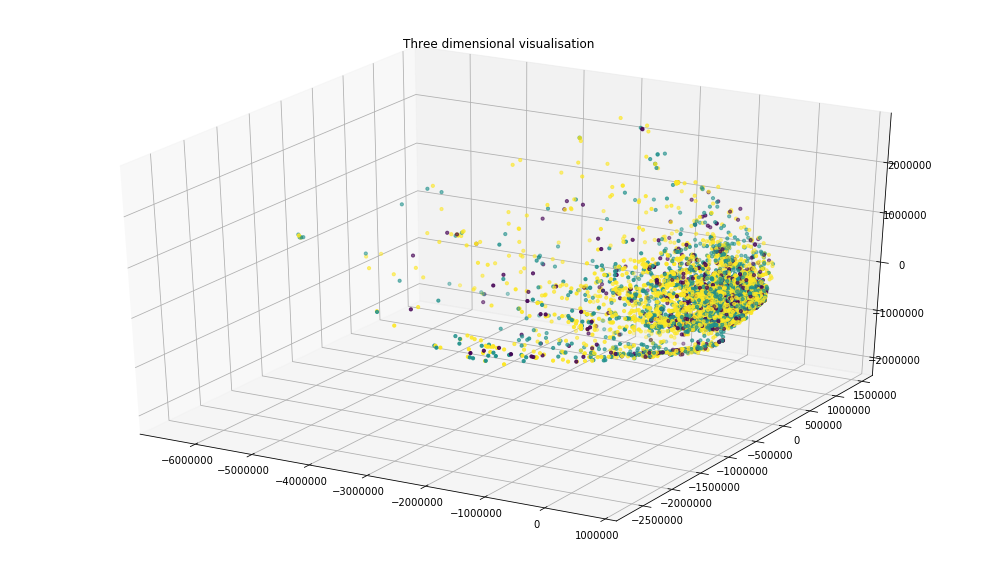

In [52]:
# colors = [cm.Vega10((y_) / max(y_train)) for y_ in y_train]

fig = plt.figure(figsize=(17.5, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_title('Three dimensional visualisation')
ax.scatter(X_train_kpca[:, 0], X_train_kpca[:, 1], X_train_kpca[:, 2], c=y_samp, s=10)
plt.show()

### t-SNE

In [53]:
X_tsne2D = np.loadtxt('X_tsne2.txt') # tsne of all data
X_tsne3D = np.loadtxt('X_train_tsne.txt') # tsne of the half of data

In [60]:
color_labels = data['age']
colors = [cm.Vega10((y_) / max(color_labels)) for y_ in color_labels]

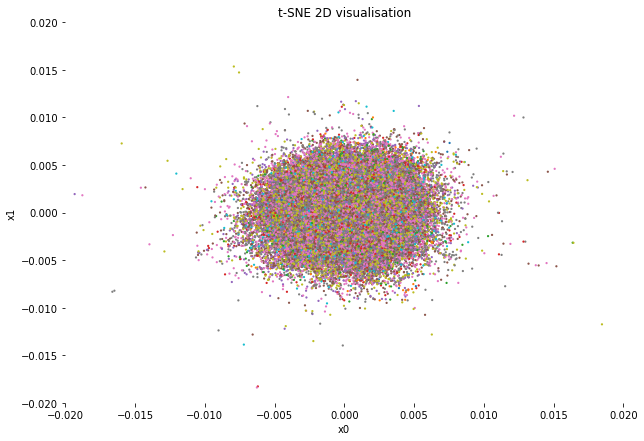

In [63]:
x0 = [x[0] for x in X_tsne2D]
x1 = [x[1] for x in X_tsne2D]
plt.figure(figsize=(10, 7))
ax = plt.axes(frameon=False)
plt.scatter(x0, x1, c=colors, edgecolor = 'none', s = 5)
plt.xlabel('x0')
plt.ylabel('x1')
ax.set_xlim([-0.02, 0.02])
ax.set_ylim([-0.02, 0.02])
plt.title('t-SNE 2D visualisation')

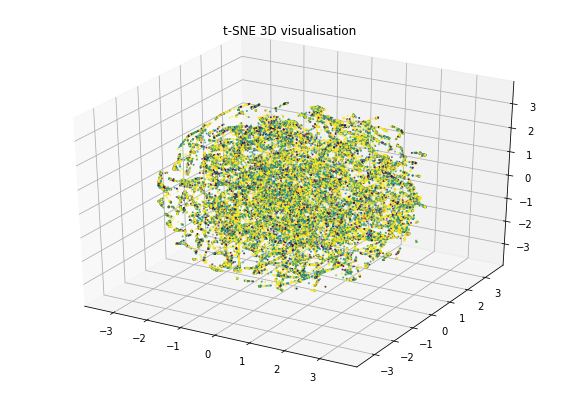

In [33]:
# colors = [cm.Vega10((y_) / max(y_train)) for y_ in y_train]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.set_title('t-SNE 3D visualisation')
ax.scatter(X_tsne3D[:, 0], X_tsne3D[:, 1], X_tsne3D[:, 2], c=y_train, s=1)
plt.show()

-------

# KDE

In [18]:
# Divide tha data with respect to labels

X0 = X_tsne2D[np.where(y == 0)[0]] 
X1 = X_tsne2D[np.where(y == 1)[0]]
X2 = X_tsne2D[np.where(y == 2)[0]]

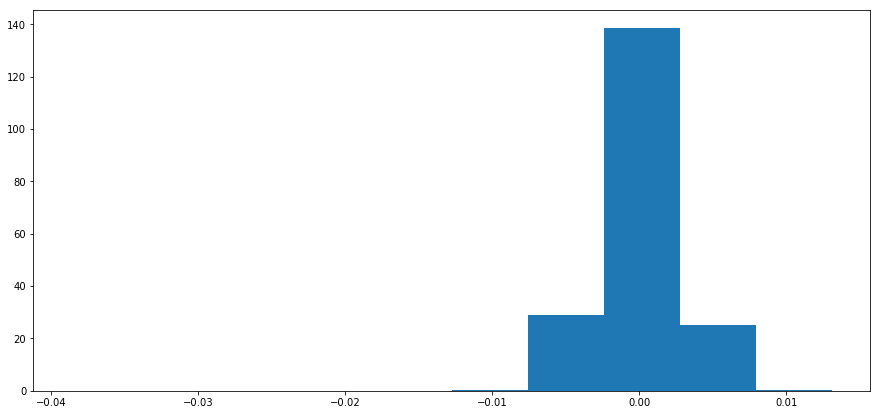

In [20]:
plt.figure(figsize=(15,7))
plt.hist(X0[:, 0], normed=True)
# plt.hist(X1[:, 1], normed=True, bins=50)
# plt.hist(X2[:, 1], normed=True, bins=50)
plt.show()

--------

# Classification
## Binary classification

### AdaBoost with random under-sampling

We have an imbalanced data, so we want to use RUS

In [230]:
rus = RandomUnderSampler()
X_train_rus, y_bin_train_rus = rus.fit_sample(X_train_med, y_bin_train)
# X_test_med_rus, y_bin_test_rus = rus.fit_sample(X_test, y_bin_test)


In [231]:
AB = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200)
print('Fitting classifier')
t0 = time()
AB.fit(X_train_rus, y_bin_train_rus)
print('Fitting is done in %s ' % (time() - t0))
print('ROC-AUC', roc_auc_score(y_score=AB.predict(X_test_med), y_true=y_bin_test))

Fitting classifier
Fitting is done in 7.204129934310913 
ROC-AUC 0.590091407392


In [61]:
y_pred_proba = AB.predict_proba(X_test)[:, 0]
precision_AB_rus, recall_AB_rus, _ = precision_recall_curve(y_true=y_bin_test, probas_pred=y_pred_proba)

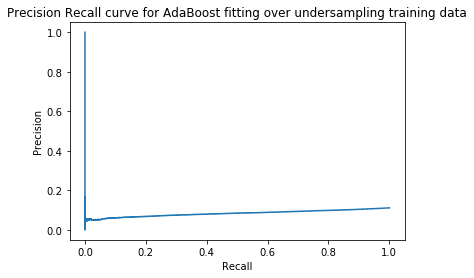

In [39]:
plt.title('Precision Recall curve for AdaBoost fitting over undersampling training data')
plt.plot(recall_AB_rus, precision_AB_rus)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### AdaBoost without RUS

In [117]:
AB = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200)

In [119]:
print('Fitting classifier')
t0 = time()
AB.fit(X_train, y_bin_train)
print('fitting is done in %s ' % (time() - t0))
print('Accuracy', accuracy_score(y_pred=AB.predict(X_test), y_true=y_bin_test))

Fitting classifier
fitting is done in 49.89542031288147 
Accuracy 0.618772478038


In [105]:
y_pred_proba = AB.predict_proba(X_test_med)[:, 0]

In [107]:
precision_AB, recall_AB, _ = precision_recall_curve(y_true=y_bin_test, probas_pred=y_pred_proba)

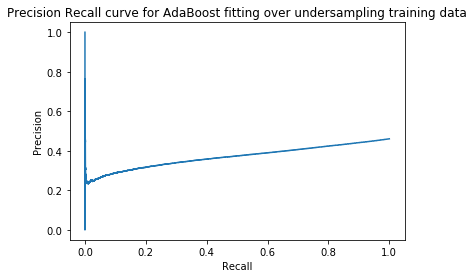

In [108]:
plt.title('Precision Recall curve for AdaBoost fitting over undersampling training data')
plt.plot(recall_AB, precision_AB)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### MLPClassifier

In [232]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic', )

In [233]:
print('Fitting classifier')
t0 = time()
mlp.fit(X_train_rus, y_bin_train_rus)
print('fitting is done in %s ' % (time() - t0))

Fitting classifier
fitting is done in 2.07297420501709 


In [234]:
print('ROC-AUC', roc_auc_score(y_score=mlp.predict(X_test_med), y_true=y_bin_test))

ROC-AUC 0.537877971196


In [292]:
# print ('Number of ones in test prediction', np.sum(mlp.predict(X_test_med)))
# print ('Number of ones in y_test', np.sum(y_bin_test))

### Naive Bayes

In [235]:
GB = GaussianNB()

In [236]:
print('Fitting classifier')
t0 = time()
GB.fit(X_train_rus, y_bin_train_rus)
print('fitting is done in %s ' % (time() - t0))

Fitting classifier
fitting is done in 0.014554977416992188 


In [237]:
print('ROC-AUC', roc_auc_score(y_score=GB.predict(X_test_med), y_true=y_bin_test))

ROC-AUC 0.575351063035


### Discriminant Analysis

In [238]:
LDA = LinearDiscriminantAnalysis()

In [239]:
LDA.fit(X_train_rus, y_bin_train_rus)

//anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [240]:
print ('LDA accuracy', roc_auc_score(y_score=LDA.predict(X_test_med), y_true=y_bin_test) )

LDA accuracy 0.587941360946


## Multiclass classification

### Random forest classifier

In [25]:
# forest = RandomForestClassifier(n_estimators=100, random_state=1)
# t0 = time()
# print("Fitting in forest..")
# forest.fit(X_train_drug, y_train)
# print("Done in %s seconds" %(time() - t0))

In [26]:
# print (accuracy_score(y_pred=forest.predict(X_test_drug), y_true=y_test))

Choosing the best parameter via grid search

In [92]:
print("Fitting the classifier to the training set..")
t0 = time()
param_grid = {'n_estimators': np.arange(100, 200, 10)}
forest = GridSearchCV(RandomForestClassifier(random_state=1), param_grid)
forest.fit(X_train_med, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(forest.best_estimator_)

Fitting the classifier to the training set..
done in 230.825s
Best estimator found by grid search:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=170, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)


In [93]:
print('Accuracy', accuracy_score(y_pred=forest.best_estimator_.predict(X_test_med), y_true=y_test))

Accuracy 0.59656443822


In [94]:
rf = forest.best_estimator_ 

Feature ranking:
1. feature 0 (0.140043)
2. feature 6 (0.131565)
3. feature 7 (0.130428)
4. feature 8 (0.124599)
5. feature 2 (0.119441)
6. feature 1 (0.054467)
7. feature 9 (0.053029)
8. feature 29 (0.033788)
9. feature 11 (0.026892)
10. feature 5 (0.021711)
11. feature 3 (0.019954)
12. feature 12 (0.019091)
13. feature 18 (0.017746)
14. feature 19 (0.016733)
15. feature 35 (0.015470)
16. feature 4 (0.012932)
17. feature 21 (0.011569)
18. feature 10 (0.011459)
19. feature 16 (0.010367)
20. feature 22 (0.010239)
21. feature 36 (0.007821)
22. feature 13 (0.004126)
23. feature 14 (0.002156)
24. feature 30 (0.002090)
25. feature 23 (0.001174)
26. feature 15 (0.000546)
27. feature 26 (0.000227)
28. feature 24 (0.000165)
29. feature 20 (0.000107)
30. feature 31 (0.000033)
31. feature 25 (0.000032)
32. feature 27 (0.000000)
33. feature 28 (0.000000)
34. feature 17 (0.000000)
35. feature 32 (0.000000)
36. feature 33 (0.000000)
37. feature 34 (0.000000)


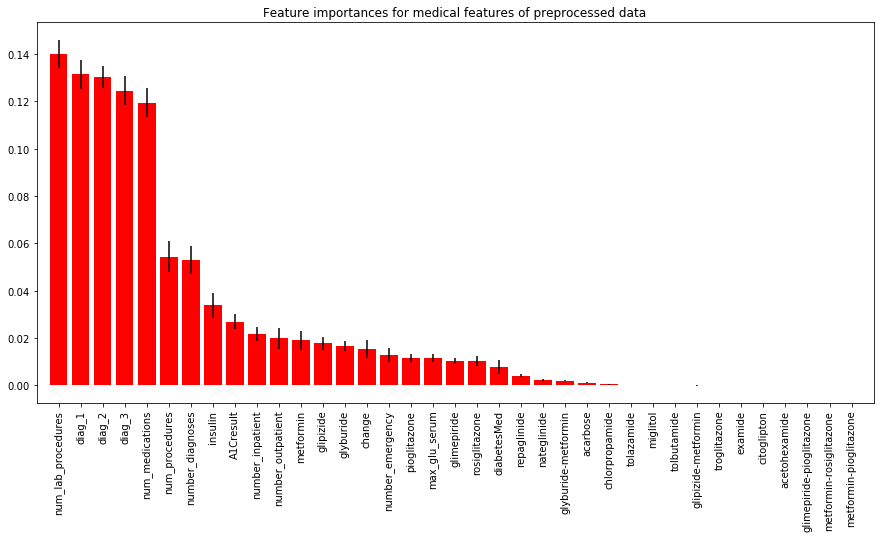

In [96]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_med.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,7))
plt.title("Feature importances for medical features of preprocessed data")
plt.bar(range(X_train_med.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_med.shape[1]), data[med_col].columns[indices], rotation='vertical')
plt.xlim([-1, X_train_med.shape[1]])
plt.show()

In [96]:
data[med_col].columns[indices[:5]]

Index(['encounter_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'race'],
      dtype='object')

-----

### OneVsRestClassifier

In [97]:
OVR = OneVsRestClassifier(estimator=LogisticRegression())

In [101]:
print('Fitting classifier')
t0 = time()
OVR.fit(X_train, y_train)
print('Fitting is done in %0.3fs' % (time() - t0))

Fitting classifier
Fitting is done in 3.262s


In [102]:
y_pred = OVR.predict(X_test)

In [103]:
print ('Accuracy', accuracy_score(y_true=y_test, y_pred=y_pred))

Accuracy 0.600194357904


### OutputCodeClassifier (without binarization)

In [104]:
OCC = OutputCodeClassifier(code_size=50, estimator=LogisticRegression())

In [107]:
OCC.fit(X_train, y_train)

OutputCodeClassifier(code_size=50,
           estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
           n_jobs=1, random_state=None)

In [108]:
print('Accuracy', accuracy_score(y_pred=OCC.predict(X_test), y_true=y_test))

Accuracy 0.60016577586


## Precision-Recall curves

In [247]:
def plot_pr_curve(methods, methods_labels, y=y, y_train=y_train, y_test=y_test, X_train=X_train_med, X_test=X_test_med, param=2):
    plt.figure(figsize=(15,10))
    #if we consider two cases <30 and (>30 and No readmittion), we do random undersampling
    if param != 2:
        y_bin, y_bin_train, y_bin_test = binarization(y, y_train, y_test, param=1)
        rus = RandomUnderSampler()
        X_train, y_bin_train = rus.fit_sample(X_train, y_bin_train)
        plt.title('Precision Recall curves with case of readmission within 30 days')
    else:
        y_bin, y_bin_train, y_bin_test = binarization(y, y_train, y_test, param=2)
        plt.title('Precision Recall curves with case of readmission')
        
    for i in range(len(methods)):
        print('Fitting %s classifier..' %i)
        t0 = time()
        methods[i].fit(X_train, y_bin_train)
        y_pred_proba = methods[i].predict_proba(X_test)[:, 0]
        y_pred = methods[i].predict(X_test)
        print('Score', roc_auc_score(y_score=y_pred, y_true=y_bin_test))
        print('fitting is done in %s ' % (time() - t0))
        precision, recall, _ = precision_recall_curve(y_true=y_bin_test, probas_pred=y_pred_proba)
        plt.plot(recall, precision, label=methods_labels[i])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    plt.legend()
    plt.show()

Fitting 0 classifier..
Score 0.601324458926
fitting is done in 46.443828105926514 
Fitting 1 classifier..
Score 0.605789717791
fitting is done in 3.711918830871582 
Fitting 2 classifier..
Score 0.603794583524
fitting is done in 0.17032814025878906 
Fitting 3 classifier..

//anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")



Score 0.598968221484
fitting is done in 0.22819995880126953 


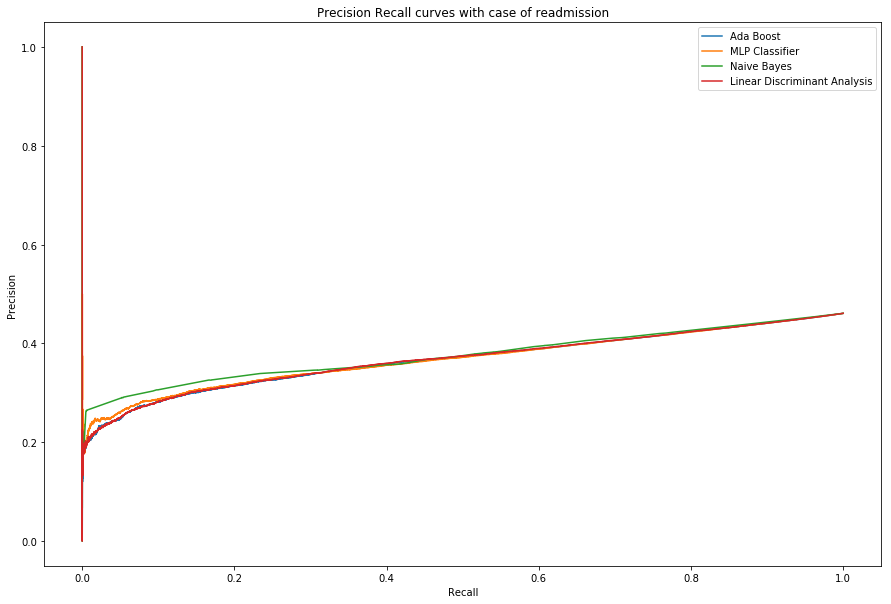

Fitting 0 classifier..
Score 0.59088058942
fitting is done in 13.882673978805542 
Fitting 1 classifier..
Score 0.588232352643
fitting is done in 1.567363977432251 
Fitting 2 classifier..
Score 0.591437819625
fitting is done in 0.10866999626159668 
Fitting 3 classifier..
Score 0.590101188282
fitting is done in 0.05584120750427246 


//anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


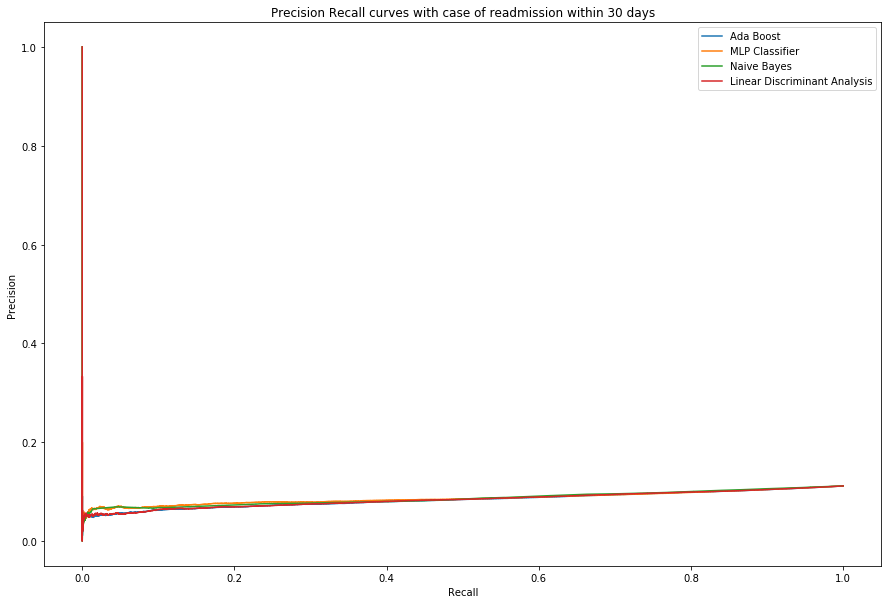

In [248]:
methods = [AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200),
          MLPClassifier(max_iter=1000, activation='logistic'),
          BernoulliNB(),
          LinearDiscriminantAnalysis()]

methods_labels = ["Ada Boost", "MLP Classifier", "Naive Bayes",  "Linear Discriminant Analysis"]

plot_pr_curve(methods, methods_labels)
plot_pr_curve(methods, methods_labels, param=1)

In [256]:
def plot_ROC_curve(methods, methods_labels, y=y, y_train=y_train, y_test=y_test, X_train=X_train_med, X_test=X_test_med, param=2):
    plt.figure(figsize=(15,10))
    #if we consider two cases <30 and (>30 and No readmittion), we do random undersampling
    if param != 2:
        y_bin, y_bin_train, y_bin_test = binarization(y, y_train, y_test, param=1)
        rus = RandomUnderSampler()
        X_train, y_bin_train = rus.fit_sample(X_train, y_bin_train)
        plt.title('ROC-curves with case bin=1')
    else:
        y_bin, y_bin_train, y_bin_test = binarization(y, y_train, y_test, param=2)
        plt.title('ROC-curves with case bin=2')
        
    for i in range(len(methods)):
        print('Fitting %s classifier..' %i)
        t0 = time()
        methods[i].fit(X_train, y_bin_train)
        y_pred_proba = methods[i].predict_proba(X_test)[:, 0]
        y_pred = methods[i].predict(X_test)
        print('Score', accuracy_score(y_pred=y_pred, y_true=y_bin_test))
        print('fitting is done in %s ' % (time() - t0))
        fpr, tpr, _ = roc_curve(y_true=y_bin_test, y_score=y_pred_proba)
        plt.plot(tpr, fpr, label=methods_labels[i])
        
        plt.xlabel('fpr')
        plt.ylabel('tpr')
    
    plt.plot(range(2), '--', label='y = x')
    plt.legend()
    plt.show()

Fitting 0 classifier..
Score 0.618084625513
fitting is done in 44.17442011833191 
Fitting 1 classifier..
Score 0.620639506318
fitting is done in 6.729956865310669 
Fitting 2 classifier..
Score 0.613171393196
fitting is done in 0.13779091835021973 
Fitting 3 classifier..


//anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Score 0.616197944304
fitting is done in 0.19136595726013184 


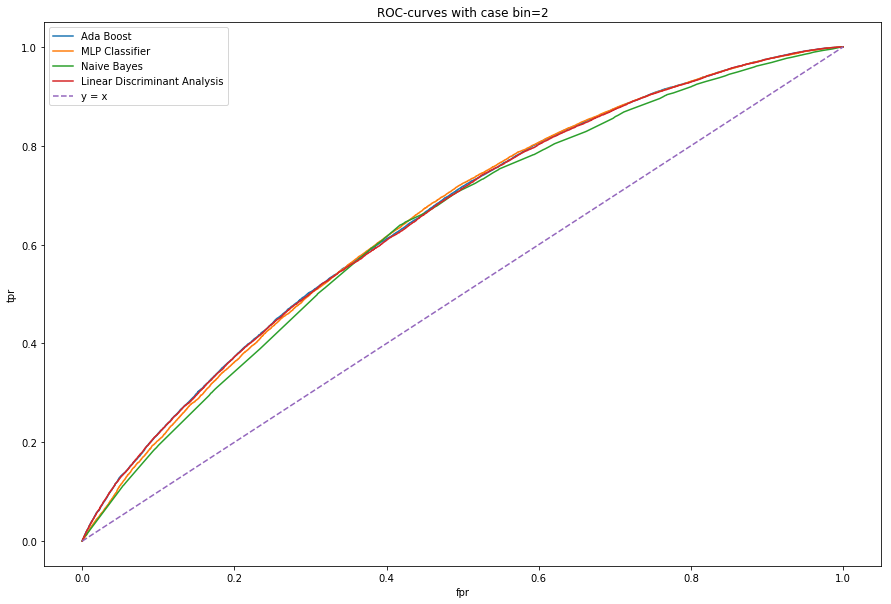

Fitting 0 classifier..
Score 0.682054910284
fitting is done in 11.702653884887695 
Fitting 1 classifier..
Score 0.822553701629
fitting is done in 3.7038190364837646 
Fitting 2 classifier..
Score 0.605152998054
fitting is done in 0.11545395851135254 
Fitting 3 classifier..
Score 0.676080419787
fitting is done in 0.052874088287353516 


//anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


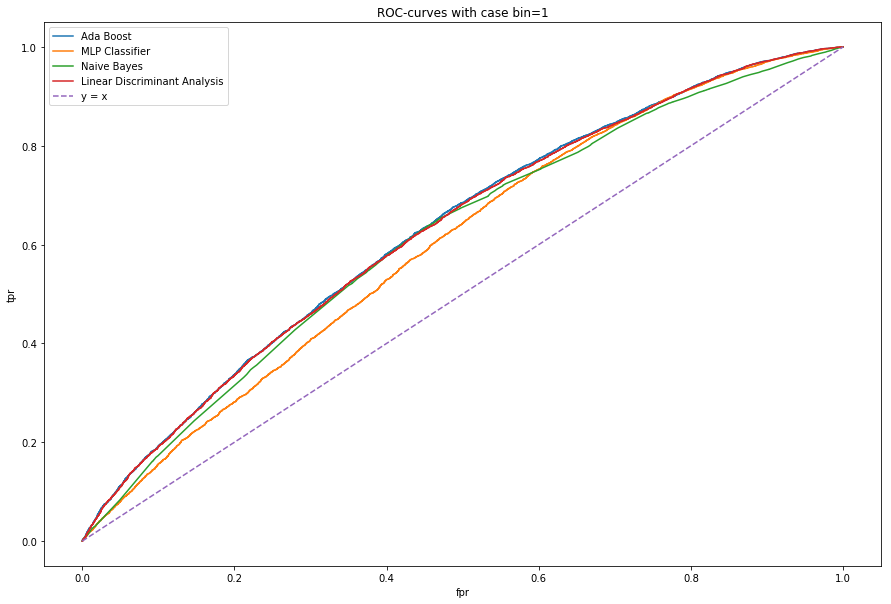

In [257]:
methods = [AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=200),
          MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic'),
          BernoulliNB(),
          LinearDiscriminantAnalysis()]

methods_labels = ["Ada Boost", "MLP Classifier", "Naive Bayes",  "Linear Discriminant Analysis"]

plot_ROC_curve(methods, methods_labels)
plot_ROC_curve(methods, methods_labels, param=1)